In [2]:
!pip install easyocr
!pip install imutils

In [3]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

In [7]:
def scanImage(imageFile):
    img = cv2.imread(imageFile)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Enhance the contrast using histogram equalization
    gray = cv2.equalizeHist(gray)

    # Sharpen the image to improve text clarity
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
    sharpened = cv2.filter2D(gray, -1, kernel)

    plt.imshow(cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB))

    # Apply filter and edges for localization
    bfilter = cv2.bilateralFilter(sharpened, 11, 17, 17)  # Noise reduction
    edged = cv2.Canny(bfilter, 30, 200)  # Edge detection

    # Find contours and apply mask
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    location = None

    # Try to locate a quadrilateral (license plate shape)
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) >= 4:  # We assume the plate is a quadrilateral
            location = approx
            break
    
    if location is None:
        print(f"License plate contour not found in {imageFile}.")
        return None  # Exit the function if no plate was found

    # Create a mask for the found contour
    mask = np.zeros(sharpened.shape, np.uint8)
    new_image = cv2.drawContours(mask, [location], 0, 255, -1)
    new_image = cv2.bitwise_and(img, img, mask=mask)

    # Crop the image to the bounding box of the contour
    (x, y) = np.where(mask == 255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = sharpened[x1:x2+1, y1:y2+1]

    # Use EasyOCR to read the text from the cropped image
    reader = easyocr.Reader(['en'])
    results = reader.readtext(cropped_image)

    plate_info = []
    
    for (bbox, text, prob) in results:
        plate_info.append({
            'text': text,
            'bbox': bbox,
            'probability': prob
        })

    # Get image dimensions
    img_height, img_width = img.shape[:2]
    
    # Initialize values for bounding box dimensions and distances
    plate_width, plate_height = 0, 0
    distance_from_top = 0
    distance_from_left = 0
    
    if plate_info:
        print(f"Detected text from {imageFile}:")
        for plate in plate_info:
            print(f"Text: {plate['text']}, BBox: {plate['bbox']}")

            # Draw the bounding box
            points = np.array(plate['bbox'], dtype=int)  # Convert to numpy array for indexing
            for i in range(4):
                cv2.line(img, tuple(points[i]), tuple(points[(i + 1) % 4]), (0, 255, 0), 2)

            # Calculate plate dimensions
            plate_width = max(points[:, 0]) - min(points[:, 0])
            plate_height = max(points[:, 1]) - min(points[:, 1])

            # Calculate distances from top and left
            distance_from_top = min(points[:, 1])  # Minimum y-coordinate gives distance from top
            distance_from_left = min(points[:, 0])  # Minimum x-coordinate gives distance from left

        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        print("No text detected.")

    # Return plate info along with image dimensions and distances
    return {
        'plate_info': plate_info,
        'image_width': img_width,
        'image_height': img_height,
        'plate_width': plate_width,
        'plate_height': plate_height,
        'distance_from_top': distance_from_top,
        'distance_from_left': distance_from_left
    }  # Return detected plates and dimensions


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Picture Frames: ['frame_18019.png', 'frame_18024.png', 'frame_18026.png', 'frame_18033.png', 'frame_18039.png', 'frame_18045.png', 'frame_18047.png', 'frame_18050.png', 'frame_18051.png', 'frame_18052.png', 'frame_18055.png', 'frame_18059.png', 'frame_18081.png', 'frame_18089.png', 'frame_18093.png', 'frame_18094.png', 'frame_18097.png', 'neg_110769.png', 'neg_178309.png', 'neg_209266.png', 'neg_271198.png', 'neg_313731.png', 'neg_414821.png', 'neg_57015.png', 'neg_69748.png', 'neg_7771.png', 'neg_84494.png']
Plate Frames: ['bus_license1.png']
Processing plate frame: bus_license1.png
Detected text from C:/Users/Owner/Documents/Hackathon/plateFrames/bus_license1.png:
Text: U7179, BBox: [[0, np.int32(3)], [np.int32(85), np.int32(3)], [np.int32(85), 44], [0, 44]]
{'plate_info': [{'text': 'U7179', 'bbox': [[0, np.int32(3)], [np.int32(85), np.int32(3)], [np.int32(85), 44], [0, 44]], 'probability': np.float64(0.5796240229660884)}], 'image_width': 94, 'image_height': 51, 'plate_width': np.int

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected text from C:/Users/Owner/Documents/Hackathon/Frames/frame_18019.png:
Text: RAv7179, BBox: [[np.int32(68), np.int32(107)], [np.int32(325), np.int32(107)], [np.int32(325), np.int32(183)], [np.int32(68), np.int32(183)]]
{'plate_info': [{'text': 'RAv7179', 'bbox': [[np.int32(68), np.int32(107)], [np.int32(325), np.int32(107)], [np.int32(325), np.int32(183)], [np.int32(68), np.int32(183)]], 'probability': np.float64(0.1562365622818337)}], 'image_width': 3840, 'image_height': 1920, 'plate_width': np.int64(257), 'plate_height': np.int64(76), 'distance_from_top': np.int64(107), 'distance_from_left': np.int64(68)}
Processing plate frame: frame_18024.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: frame_18026.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: frame_18033.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: frame_18039.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: frame_18045.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: frame_18047.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected text from C:/Users/Owner/Documents/Hackathon/Frames/frame_18047.png:
Text: RAUtL, BBox: [[np.int32(72), np.int32(117)], [np.int32(287), np.int32(117)], [np.int32(287), np.int32(193)], [np.int32(72), np.int32(193)]]
{'plate_info': [{'text': 'RAUtL', 'bbox': [[np.int32(72), np.int32(117)], [np.int32(287), np.int32(117)], [np.int32(287), np.int32(193)], [np.int32(72), np.int32(193)]], 'probability': np.float64(0.08969278402442296)}], 'image_width': 3840, 'image_height': 1920, 'plate_width': np.int64(215), 'plate_height': np.int64(76), 'distance_from_top': np.int64(117), 'distance_from_left': np.int64(72)}
Processing plate frame: frame_18050.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: frame_18051.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: frame_18052.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: frame_18055.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: frame_18059.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected text from C:/Users/Owner/Documents/Hackathon/Frames/frame_18059.png:
Text: "9052529, BBox: [[np.int32(204), np.int32(296)], [np.int32(296), np.int32(296)], [np.int32(296), np.int32(324)], [np.int32(204), np.int32(324)]]
Text: RAUZ179, BBox: [[np.int32(74), np.int32(393)], [np.int32(355), np.int32(393)], [np.int32(355), np.int32(470)], [np.int32(74), np.int32(470)]]
Text: Fl, BBox: [[np.int32(347), np.int32(441)], [np.int32(377), np.int32(441)], [np.int32(377), np.int32(461)], [np.int32(347), np.int32(461)]]
Text: 179, BBox: [[np.int32(241), np.int32(555)], [np.int32(297), np.int32(555)], [np.int32(297), np.int32(591)], [np.int32(241), np.int32(591)]]
{'plate_info': [{'text': '"9052529', 'bbox': [[np.int32(204), np.int32(296)], [np.int32(296), np.int32(296)], [np.int32(296), np.int32(324)], [np.int32(204), np.int32(324)]], 'probability': np.float64(0.4839426937232573)}, {'text': 'RAUZ179', 'bbox': [[np.int32(74), np.int32(393)], [np.int32(355), np.int32(393)], [np.int32(355), n

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: frame_18089.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected text from C:/Users/Owner/Documents/Hackathon/Frames/frame_18089.png:
Text: u7l79, BBox: [[np.int32(139), np.int32(115)], [np.int32(243), np.int32(115)], [np.int32(243), np.int32(159)], [np.int32(139), np.int32(159)]]
{'plate_info': [{'text': 'u7l79', 'bbox': [[np.int32(139), np.int32(115)], [np.int32(243), np.int32(115)], [np.int32(243), np.int32(159)], [np.int32(139), np.int32(159)]], 'probability': np.float64(0.41232418851200764)}], 'image_width': 3840, 'image_height': 1920, 'plate_width': np.int64(104), 'plate_height': np.int64(44), 'distance_from_top': np.int64(115), 'distance_from_left': np.int64(139)}
Processing plate frame: frame_18093.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: frame_18094.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: frame_18097.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: neg_110769.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: neg_178309.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: neg_209266.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected text from C:/Users/Owner/Documents/Hackathon/Frames/neg_209266.png:
Text: bbnTE, BBox: [[np.int32(185), np.int32(313)], [np.int32(249), np.int32(313)], [np.int32(249), np.int32(329)], [np.int32(185), np.int32(329)]]
Text: 06+, BBox: [[np.int32(352), np.int32(566)], [np.int32(412), np.int32(566)], [np.int32(412), np.int32(594)], [np.int32(352), np.int32(594)]]
{'plate_info': [{'text': 'bbnTE', 'bbox': [[np.int32(185), np.int32(313)], [np.int32(249), np.int32(313)], [np.int32(249), np.int32(329)], [np.int32(185), np.int32(329)]], 'probability': np.float64(0.004746333365215391)}, {'text': '06+', 'bbox': [[np.int32(352), np.int32(566)], [np.int32(412), np.int32(566)], [np.int32(412), np.int32(594)], [np.int32(352), np.int32(594)]], 'probability': np.float64(0.290497766078791)}], 'image_width': 3840, 'image_height': 1920, 'plate_width': np.int64(60), 'plate_height': np.int64(28), 'distance_from_top': np.int64(566), 'distance_from_left': np.int64(352)}
Processing plate frame: neg_27

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: neg_313731.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: neg_414821.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: neg_57015.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: neg_69748.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected text from C:/Users/Owner/Documents/Hackathon/Frames/neg_69748.png:
Text: R, BBox: [[np.int32(139), np.int32(353)], [np.int32(153), np.int32(353)], [np.int32(153), np.int32(377)], [np.int32(139), np.int32(377)]]
Text: P9Q70, BBox: [[np.int32(168), np.int32(344)], [np.int32(264), np.int32(344)], [np.int32(264), np.int32(384)], [np.int32(168), np.int32(384)]]
{'plate_info': [{'text': 'R', 'bbox': [[np.int32(139), np.int32(353)], [np.int32(153), np.int32(353)], [np.int32(153), np.int32(377)], [np.int32(139), np.int32(377)]], 'probability': np.float64(0.3917090655036759)}, {'text': 'P9Q70', 'bbox': [[np.int32(168), np.int32(344)], [np.int32(264), np.int32(344)], [np.int32(264), np.int32(384)], [np.int32(168), np.int32(384)]], 'probability': np.float64(0.5058458206434315)}], 'image_width': 3840, 'image_height': 1920, 'plate_width': np.int64(96), 'plate_height': np.int64(40), 'distance_from_top': np.int64(344), 'distance_from_left': np.int64(168)}
Processing plate frame: neg_7771.png

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Processing plate frame: neg_84494.png


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


No text detected.
Unique Plates Found: {'bus_license1': 'U7179'}
JSON Return: ['RAv7179', 'RAUtL', '"9052529', 'u7l79', 'bbnTE', 'R']


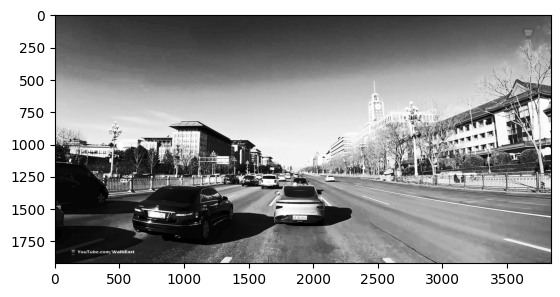

In [14]:
def Main():
    platesValues = {}
    jsonReturn = []
    pictureFrameLocation = "C:/Users/Owner/Documents/Hackathon/Frames/"
    plateFrameLocation = "C:/Users/Owner/Documents/Hackathon/plateFrames/"
    
    pictureFrame = [file for file in os.listdir(pictureFrameLocation) if file.endswith('.png')]  # Frame file array
    plateFrame = [file for file in os.listdir(plateFrameLocation) if file.endswith('.png')]  # Plates file array

    print("Picture Frames:", pictureFrame)
    print("Plate Frames:", plateFrame)

    for plateFrameFile in plateFrame:
        print(f"Processing plate frame: {plateFrameFile}")
        result = scanImage(plateFrameLocation + plateFrameFile)
        if result and result['plate_info']:
            print(result)
            platesValues[plateFrameFile.removesuffix('.png')] = result['plate_info'][0]['text'].upper()
            print("Unique Plates Found:", platesValues)
    for pictureFrameFile in pictureFrame:
        print(f"Processing plate frame: {pictureFrameFile}")
        result = scanImage(pictureFrameLocation + pictureFrameFile)
        if result and result['plate_info']:
            print(result)
            jsonReturn.append(result['plate_info'][0]['text'])

    print("Unique Plates Found:", platesValues)
    print("JSON Return:", jsonReturn)

if __name__ == "__main__":
    Main()
